In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import PolynomialFeatures

In [18]:
import matplotlib

matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

In [19]:
def h(theta, x):
    '''
    预测函数
    Args:
        theta 模型参数
        X 特征向量
    Return:
        预测结果
    '''
    return np.dot(x, theta)

In [20]:
def J(theta, X, y, theLambda=0):
    '''
    代价函数
    Args:
        theta 模型参数
        X 样本特征
        y 样本标签
    Return:
        预测误差
    '''
    m, n = X.shape
    return (h(theta, X) - y).T * (h(theta,X) -y) / (2 * m) + theLambda * np.sum(np.square(theta)) / (2*m)

In [21]:
def gradient(X, y, alpha, maxLoop=50, epsilon=1e-5, theLambda=0, initTheta=None):
    '''
    批量梯度下降
    Args:
        X 样本特征
        y 样本标签
        alpha 学习率
        maxLoop 最大迭代次数
        epsilon 收敛精度
        theLambda 正则化参数
        initTheta 初始化参数
    Returns:
        theta, errors
    '''
    m, n = X.shape
    converged = False
    # 初始化theta
    if initTheta is None:
        theta = np.zeros((n,1))
    else:
        theta = initTheta
    count = 0
    
    error = np.inf
    errors = [error]
    while count <= maxLoop:
        if converged :
            break
        count += 1
        theta = theta + (1.0 / m) * alpha * ((y - X * theta).T * X).T
        error = J(theta, X, y, theLambda)
        if np.isnan(error):
            error = np.inf
        errors.append(error)
        # 如果已经收敛
        if abs(errors[-1]-errors[-2]) < epsilon:
            break
    return theta, errors
            

In [22]:
def normalize(X):
    '''
    特征归一化处理
    Args:
        X 样本集
    Returns:
        归一化后的样本集    
    '''
    m, n = X.shape
    for j in range(n):
        features = X[:,j]
        minVal = features.min(axis=0)
        maxVal = features.max(axis=0)
        diff = maxVal-minVal
        if diff != 0:
            X[:,j] = (features - minVal)/diff
        else:
            X[:,j] = 0
    return X
        

In [23]:
data = loadmat('data/water.mat')
X = np.mat(data['X'])
# 训练集
X = np.concatenate((np.ones((X.shape[0],1)), X),axis = 1)
y = np.mat(data['y'])
# 交叉验证集
Xval = np.mat(data['Xval'])
Xval = np.concatenate((np.ones((Xval.shape[0], 1)), Xval), axis=1)
yval = np.mat(data['yval'])
# 测试集
Xtest = np.mat(data['Xtest'])
Xtest = np.concatenate((np.ones((Xtest.shape[0], 1)), Xtest), axis=1)
ytest = np.mat(data['ytest'])

In [35]:
def diagnoseLR():
    """线性回归诊断
    """
    initTheta = np.mat(np.ones((X.shape[1], 1)))
    theta, errors = gradient(
        X, y, alpha=0.001, maxLoop=5000, epsilon=0.00001, initTheta=initTheta)

    # 绘制拟合成果
    Xmin = X[:, 1].min()
    Xmax = X[:, 1].max()
    ymax = y[:, 0].max()
    ymin = y[:, 0].min()
    fitX = np.mat(np.linspace(Xmin, Xmax, 20).reshape(-1, 1))
    fitX = np.concatenate((np.ones((fitX.shape[0], 1)), fitX), axis=1)

    h = fitX * theta
    plt.xlim(Xmin, Xmax)
    plt.ylim(ymin, ymax)
    # 绘制训练样本
    plt.scatter(X[:, 1].tolist(), y[:, 0].tolist(),marker='x',color='r', linewidth=2)
    # 绘制拟合曲线
    plt.plot(fitX[:, 1], h, color='b')
    plt.xlabel(u'水位变化(x)')
    plt.ylabel(u'大坝流量(y)')
    plt.show()

    # 绘制随样本规模学习曲线
    m, n = X.shape
    trainErrors = np.zeros((1,m))
    valErrors = np.zeros((1,m))
    for i in range(m):
        Xtrain = X[0:i+1]
        ytrain = y[0:i+1]
        # 注意，这里我们没有设置theLambda，实际上没有必要
        theta, errors = gradient(
            Xtrain, ytrain, alpha=0.001, maxLoop=10000, epsilon=0.00001)
        
        trainErrors[0,i] = J(theta, Xtrain, ytrain)
        valErrors[0,i] = J(theta, Xval, yval)

    print(u'最小交叉验证误差', valErrors.ravel()[-1])
    plt.plot(np.arange(1,m+1).ravel(), trainErrors.ravel(), color='b', label=u'训练误差')
    plt.plot(np.arange(1,m+1).ravel(), valErrors.ravel(), color='g', label=u'交叉验证误差')
    plt.title(u'线性回归学习曲线')
    plt.xlabel(u'训练样本量')
    plt.ylabel(u'误差')
    plt.legend()
    plt.show()

In [36]:
np.ravel?

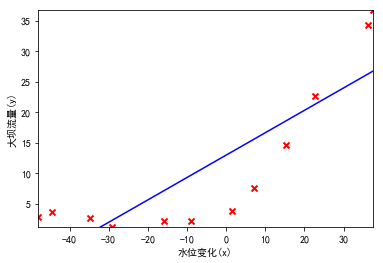

最小交叉验证误差 29.564752654802668


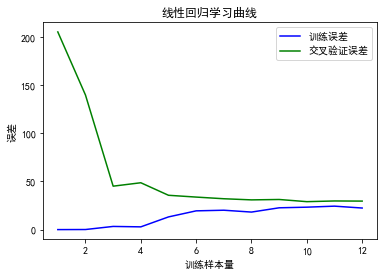

In [37]:
diagnoseLR()

In [33]:
def diagnosePR():
    """多项式回归诊断
    """
    # 多项式回归
    poly = PolynomialFeatures(degree=10)
    XX, XXval, XXtest = [normalize(
        np.mat(poly.fit_transform(data[:, 1:]))) for data in [X, Xval, Xtest]]
    initTheta = np.mat(np.ones((XX.shape[1], 1)))
    theLambdas = [0, 0.01, 0.02, 0.03, 0.04, 0.05,0.06,0.07, 0.08, 0.09,0.10, 0.11, 0.12,0.13,0.14,0.15,0.2,0.3,0.5]
    numTheLambdas = len(theLambdas)
    trainErrors = np.zeros((1, numTheLambdas))
    valErrors = np.zeros((1, numTheLambdas))
    thetas = []
    for idx, theLambda in enumerate(theLambdas):
        theta, errors = gradient(
            XX, y, alpha=0.1, maxLoop=10000, epsilon=0.0001,
            theLambda=theLambda, initTheta=initTheta)
        
        thetas.append(theta)
        # 训练误差、交叉验证误差，不需要考虑模型复杂度，所以theLambda不需要设置或者设置成0
        trainErrors[0, idx] = J(theta,XX,y)
        valErrors[0, idx] = J(theta, XXval, yval)
        print(theLambda, valErrors[0,idx])

    bestLambda = theLambdas[np.argmin(valErrors)]
    theta = thetas[np.argmin(valErrors)]
    error = np.min(valErrors)
    print('the best one:',bestLambda, error)

    # # 选择lambda
    plt.plot(theLambdas, trainErrors.ravel(), color='b',label=u'训练误差')
    plt.plot(theLambdas, valErrors.ravel(), color='g',label=u'交叉验证误差')
    plt.title(u'多项式回归选择λ')
    plt.xlabel(u'λ')
    plt.ylabel(u'误差')
    plt.legend()
    plt.show()

    # 绘制拟合曲线
    fitX = np.mat(np.linspace(-60, 45).reshape(-1, 1))
    fitX = np.concatenate((np.ones((fitX.shape[0], 1)), fitX), axis=1)
    fitXX = normalize(np.mat(poly.fit_transform(fitX[:, 1:])))
    h = fitXX * theta
    print(theta)
    plt.title(u'多项式回归拟合曲线(lambda=%.3f) \n  交叉验证误差=%.3f' % (bestLambda, error))
    
    plt.scatter(X[:, 1].tolist(), y[:, 0].tolist(), marker='x', color='r', linewidth=3)
    plt.plot(fitX[:, 1], h, color='b')
    plt.show()

0 15.243389466469202
0.01 15.012599523662516
0.02 14.76196366423922
0.03 14.529461480173763
0.04 14.33384327902734
0.05 14.1872899757646
0.06 14.093184875253355
0.07 14.053284486207568
0.08 14.061918063936224
0.09 14.112333334428364
0.1 14.198147212683498
0.11 14.311753596608908
0.12 14.445531704002516
0.13 14.600809651263196
0.14 14.76189813136848
0.15 14.936084971453134
0.2 15.934299059503648
0.3 16.471327701795325
0.5 22.224487377564373
the best one: 0.07 14.053284486207568


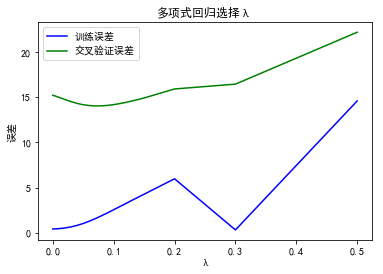

[[  1.        ]
 [ 33.95102063]
 [ 18.6465778 ]
 [ 12.39603696]
 [  6.03626333]
 [ -0.35284465]
 [ -2.41587214]
 [ -8.76756631]
 [ -7.44441674]
 [-14.36476901]
 [-10.39025965]]


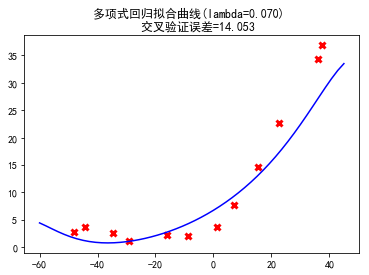

In [34]:
diagnosePR()